In [61]:
"""
Brain-Computer Interface Classifier with Wavelet Transform
For EEG signal relaxation/focus state classification
USE WAVELET TRANSFORM FEATURES AS INPUT
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import os
import glob
import warnings
import pywt
import scipy.signal as signal
from scipy.signal import butter, lfilter
warnings.filterwarnings('ignore')


In [ ]:
# 參數設置
SAMPLING_RATE = 500
SEGMENT_LENGTH = 5    # 2 ~ 6 秒
OVERLAP_RATIO = 0.0   #0.0 ~ 0.8
# 小波變換參數
WAVELET_NAME = 'morl'  # Morlet小波
TOTAL_SCALES = 64      # 尺度數量
FREQ_RANGE = (8, 30)   # 感興趣的頻率範圍 (Hz)
FILTER_LOWCUT = 0.5    # 帶通濾波器低截止頻率
FILTER_HIGHCUT = 30    # 帶通濾波器高截止頻率
FILTER_ORDER = 5       # 濾波器階數


In [63]:
# 信號預處理函數
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """帶通濾波器"""
    nyq = 0.5 * fs 
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    y = signal.filtfilt(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    """設計帶通濾波器"""
    nyq = 0.5 * fs 
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

# 小波變換函數
def continuous_wavelet_transform(signal_data, sampling_rate, wavelet_name='morl', total_scales=64):
    """連續小波變換"""
    fc = pywt.central_frequency(wavelet_name)
    cparam = 2 * fc * total_scales
    scales = cparam / np.arange(1, total_scales + 1)
    
    cwtmatr, frequencies = pywt.cwt(signal_data, scales, wavelet_name, 1.0/sampling_rate)
    return cwtmatr, frequencies

def extract_wavelet_features(signal_data, sampling_rate, freq_range=(8, 30)):
    """提取小波特徵"""
    # 帶通濾波
    filtered_data = butter_bandpass_filter(signal_data, FILTER_LOWCUT, FILTER_HIGHCUT, sampling_rate)
    
    # 小波變換
    cwtmatr, frequencies = continuous_wavelet_transform(filtered_data, sampling_rate, WAVELET_NAME, TOTAL_SCALES)
    
    # 選擇感興趣的頻率範圍
    freq_mask = (frequencies >= freq_range[0]) & (frequencies <= freq_range[1])
    selected_cwt = cwtmatr[freq_mask, :]
    
    # 提取特徵：功率譜密度
    power_features = np.abs(selected_cwt) ** 2
    
    # 計算統計特徵
    features = []
    for i in range(power_features.shape[0]):
        # 每個頻率成分的統計特徵
        features.extend([
            np.mean(power_features[i, :]),      # 平均功率
            np.std(power_features[i, :]),       # 功率標準差
            np.max(power_features[i, :]),       # 最大功率
            np.min(power_features[i, :])        # 最小功率
        ])
    
    return np.array(features)

# Data Loading and Processing
def load_eeg_data(subject_path):
    """Load EEG data for a single subject"""
    relax_file = os.path.join(subject_path, "1.txt")
    focus_file = os.path.join(subject_path, "2.txt")
    
    try:
        relax_data = np.loadtxt(relax_file)
        focus_data = np.loadtxt(focus_file)
        return relax_data, focus_data
    except Exception as e:
        print(f"Error loading data for {subject_path}: {e}")
        return None, None


In [64]:
# 顯示所有波形的時頻分析
def plot_all_waveforms_analysis():
    """顯示所有受試者的波形時頻分析"""
    print("開始分析所有受試者的波形...")
    
    # 找到所有受試者文件夾
    subject_folders = sorted(glob.glob(os.path.join("bci_dataset_113-2", "S*")))
    
    if not subject_folders:
        print("未找到受試者數據")
        return
    
    # 限制顯示的受試者數量（避免圖太多）
    max_subjects = min(20, len(subject_folders))
    subject_folders = subject_folders[:max_subjects]
    
    fig, axes = plt.subplots(max_subjects, 3, figsize=(18, 4*max_subjects))
    if max_subjects == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('All Subjects Wavelet Time-Frequency Analysis', fontsize=16)
    
    for i, subject_folder in enumerate(subject_folders):
        subject_id = os.path.basename(subject_folder)
        
        # 加載數據
        relax_data, focus_data = load_eeg_data(subject_folder)
        
        if relax_data is None or focus_data is None:
            continue
        
        # 選擇數據段（前5秒）
        segment_length = int(5 * SAMPLING_RATE)
        relax_segment = relax_data[:segment_length]
        focus_segment = focus_data[:segment_length]
        
        # 分析放鬆狀態
        try:
            relax_cwt, relax_freq = continuous_wavelet_transform(relax_segment, SAMPLING_RATE, WAVELET_NAME, 32)
            time_axis = np.arange(len(relax_segment)) / SAMPLING_RATE
            
            # 放鬆狀態時頻圖
            im1 = axes[i, 0].contourf(time_axis, relax_freq, np.abs(relax_cwt), levels=20, cmap='jet')
            axes[i, 0].set_title(f'{subject_id} - Relax State')
            axes[i, 0].set_xlabel('Time (s)')
            axes[i, 0].set_ylabel('Frequency (Hz)')
            axes[i, 0].set_ylim([0, 30])
            
        except Exception as e:
            axes[i, 0].text(0.5, 0.5, f'Error: {str(e)[:20]}...', 
                           horizontalalignment='center', verticalalignment='center',
                           transform=axes[i, 0].transAxes)
            axes[i, 0].set_title(f'{subject_id} - Relax State (Error)')
        
        # 分析專注狀態
        try:
            focus_cwt, focus_freq = continuous_wavelet_transform(focus_segment, SAMPLING_RATE, WAVELET_NAME, 32)
            
            # 專注狀態時頻圖
            im2 = axes[i, 1].contourf(time_axis, focus_freq, np.abs(focus_cwt), levels=20, cmap='jet')
            axes[i, 1].set_title(f'{subject_id} - Focus State')
            axes[i, 1].set_xlabel('Time (s)')
            axes[i, 1].set_ylabel('Frequency (Hz)')
            axes[i, 1].set_ylim([0, 30])
            
        except Exception as e:
            axes[i, 1].text(0.5, 0.5, f'Error: {str(e)[:20]}...', 
                           horizontalalignment='center', verticalalignment='center',
                           transform=axes[i, 1].transAxes)
            axes[i, 1].set_title(f'{subject_id} - Focus State (Error)')
        
        # 差異圖（專注 - 放鬆）
        try:
            # 確保兩個時頻圖的維度相同
            min_freq_len = min(relax_cwt.shape[0], focus_cwt.shape[0])
            min_time_len = min(relax_cwt.shape[1], focus_cwt.shape[1])
            
            relax_cwt_trimmed = relax_cwt[:min_freq_len, :min_time_len]
            focus_cwt_trimmed = focus_cwt[:min_freq_len, :min_time_len]
            
            # 計算功率差異
            power_diff = np.abs(focus_cwt_trimmed) ** 2 - np.abs(relax_cwt_trimmed) ** 2
            
            # 差異熱圖
            im3 = axes[i, 2].contourf(time_axis[:min_time_len], relax_freq[:min_freq_len], 
                                   power_diff, levels=20, cmap='RdBu_r')
            axes[i, 2].set_title(f'{subject_id} - Power Difference (Focus - Relax)')
            axes[i, 2].set_xlabel('Time (s)')
            axes[i, 2].set_ylabel('Frequency (Hz)')
            axes[i, 2].set_ylim([0, 30])
            
        except Exception as e:
            axes[i, 2].text(0.5, 0.5, f'Error: {str(e)[:20]}...', 
                           horizontalalignment='center', verticalalignment='center',
                           transform=axes[i, 2].transAxes)
            axes[i, 2].set_title(f'{subject_id} - Difference (Error)')
    
    plt.tight_layout()
  #  plt.savefig('all_subjects_wavelet_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("所有受試者波形分析完成！")


In [65]:
# 合併熱成像功能
def create_combined_heatmap():
    """創建所有受試者的合併熱成像圖"""
    print("開始創建合併熱成像圖...")
    
    # 找到所有受試者文件夾
    subject_folders = sorted(glob.glob(os.path.join("bci_dataset_113-2", "S*")))
    
    if not subject_folders:
        print("未找到受試者數據")
        return
    
    # 限制受試者數量
    max_subjects = min(8, len(subject_folders))
    subject_folders = subject_folders[:max_subjects]
    
    # 存儲所有受試者的時頻數據
    all_relax_data = []
    all_focus_data = []
    subject_names = []
    
    for subject_folder in subject_folders:
        subject_id = os.path.basename(subject_folder)
        
        # 加載數據
        relax_data, focus_data = load_eeg_data(subject_folder)
        
        if relax_data is None or focus_data is None:
            continue
        
        # 選擇數據段（前3秒）
        segment_length = int(3 * SAMPLING_RATE)
        relax_segment = relax_data[:segment_length]
        focus_segment = focus_data[:segment_length]
        
        try:
            # 小波變換
            relax_cwt, relax_freq = continuous_wavelet_transform(relax_segment, SAMPLING_RATE, WAVELET_NAME, 32)
            focus_cwt, focus_freq = continuous_wavelet_transform(focus_segment, SAMPLING_RATE, WAVELET_NAME, 32)
            
            # 選擇感興趣的頻率範圍
            freq_mask = (relax_freq >= FREQ_RANGE[0]) & (relax_freq <= FREQ_RANGE[1])
            relax_cwt_selected = relax_cwt[freq_mask, :]
            focus_cwt_selected = focus_cwt[freq_mask, :]
            
            # 計算平均功率
            relax_power = np.mean(np.abs(relax_cwt_selected) ** 2, axis=1)
            focus_power = np.mean(np.abs(focus_cwt_selected) ** 2, axis=1)
            
            all_relax_data.append(relax_power)
            all_focus_data.append(focus_power)
            subject_names.append(subject_id)
            
        except Exception as e:
            print(f"處理 {subject_id} 時出錯: {e}")
            continue
    
    if not all_relax_data:
        print("沒有成功處理任何受試者數據")
        return
    
    # 創建合併熱圖
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Combined Heatmap Analysis', fontsize=16)
    
    # 轉換為numpy數組
    relax_matrix = np.array(all_relax_data)
    focus_matrix = np.array(all_focus_data)
    
    # 頻率軸
    freq_axis = relax_freq[freq_mask]
    
    # 1. 放鬆狀態熱圖
    im1 = axes[0, 0].imshow(relax_matrix, aspect='auto', cmap='jet', 
                           extent=[0, relax_matrix.shape[1], freq_axis[0], freq_axis[-1]])
    axes[0, 0].set_title('Relax State - All Subjects')
    axes[0, 0].set_xlabel('Time Points')
    axes[0, 0].set_ylabel('Frequency (Hz)')
    axes[0, 0].set_yticks(range(0, len(freq_axis), 5))
    axes[0, 0].set_yticklabels([f'{freq_axis[i]:.1f}' for i in range(0, len(freq_axis), 5)])
    plt.colorbar(im1, ax=axes[0, 0], label='Power')
    
    # 2. 專注狀態熱圖
    im2 = axes[0, 1].imshow(focus_matrix, aspect='auto', cmap='jet',
                           extent=[0, focus_matrix.shape[1], freq_axis[0], freq_axis[-1]])
    axes[0, 1].set_title('Focus State - All Subjects')
    axes[0, 1].set_xlabel('Time Points')
    axes[0, 1].set_ylabel('Frequency (Hz)')
    axes[0, 1].set_yticks(range(0, len(freq_axis), 5))
    axes[0, 1].set_yticklabels([f'{freq_axis[i]:.1f}' for i in range(0, len(freq_axis), 5)])
    plt.colorbar(im2, ax=axes[0, 1], label='Power')
    
    # 3. 差異熱圖（專注 - 放鬆）
    diff_matrix = focus_matrix - relax_matrix
    im3 = axes[1, 0].imshow(diff_matrix, aspect='auto', cmap='RdBu_r',
                           extent=[0, diff_matrix.shape[1], freq_axis[0], freq_axis[-1]])
    axes[1, 0].set_title('Power Difference (Focus - Relax)')
    axes[1, 0].set_xlabel('Time Points')
    axes[1, 0].set_ylabel('Frequency (Hz)')
    axes[1, 0].set_yticks(range(0, len(freq_axis), 5))
    axes[1, 0].set_yticklabels([f'{freq_axis[i]:.1f}' for i in range(0, len(freq_axis), 5)])
    plt.colorbar(im3, ax=axes[1, 0], label='Power Difference')
    
    # 4. 平均功率比較
    mean_relax = np.mean(relax_matrix, axis=0)
    mean_focus = np.mean(focus_matrix, axis=0)
    
    axes[1, 1].plot(freq_axis, mean_relax, 'b-', label='Relax', linewidth=2)
    axes[1, 1].plot(freq_axis, mean_focus, 'r-', label='Focus', linewidth=2)
    axes[1, 1].set_title('Average Power Spectrum Comparison')
    axes[1, 1].set_xlabel('Frequency (Hz)')
    axes[1, 1].set_ylabel('Average Power')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('combined_heatmap_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("合併熱成像圖創建完成！")
    print(f"處理了 {len(subject_names)} 個受試者: {', '.join(subject_names)}")


開始顯示所有波形分析...
開始分析所有受試者的波形...


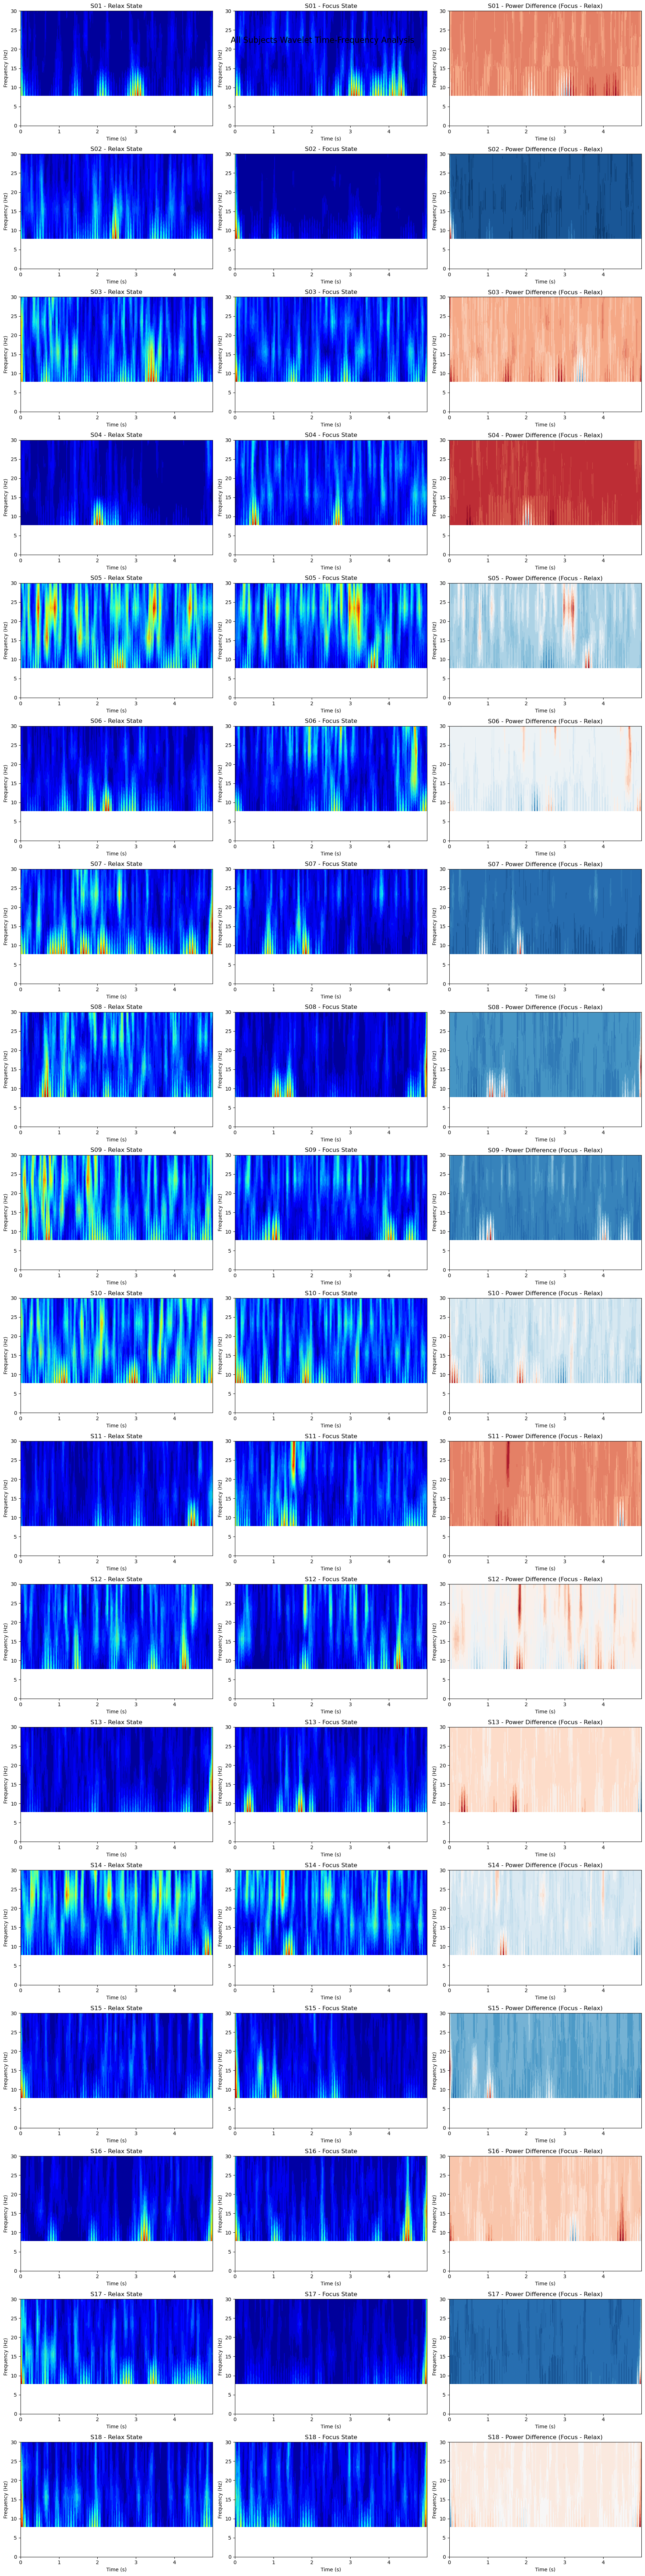

所有受試者波形分析完成！


In [66]:
# 執行所有波形分析
print("開始顯示所有波形分析...")
plot_all_waveforms_analysis()
